#### Markov Chains

In [1]:
import networkx as nx
import pandas as pd
from pomegranate import ConditionalProbabilityTable, DiscreteDistribution, MarkovChain


def initialise_markov_chain(prior_prob, cpd):
    d1 = DiscreteDistribution(prior_prob)
    d2 = ConditionalProbabilityTable(cpd, [d1])
    clf = MarkovChain([d1, d2])
    return clf


def compute_probability_sequence(seq, clf):
    print(clf.log_probability(seq))


def generate_random_sample_from_model(clf, length, num_seqs):
    df = pd.DataFrame(columns=["sequences"])
    for i in range(num_seqs):
        obs = clf.sample(length)
        df = df.append({"sequences": obs}, ignore_index=True)
    return df


def build_markov_chain_from_data(df):
    seq = list(df["sequences"])
    model = MarkovChain.from_samples(seq)
    return model


def create_markov_networkx_object(model):
    cpd = model.distributions[1].to_dict()["table"]
    states = list(model.distributions[0].to_dict()["parameters"][0].keys())
    G = nx.MultiDiGraph()
    G.add_nodes_from(states)
    for k, l, v in cpd:
        tmp_origin, tmp_destination = k, l
        G.add_edge(tmp_origin, tmp_destination, weight=v, label=v[0:4])
    return G


In [3]:

prior_prob = {"S": 0.5, "I": 0.2, "R": 0.3}
cpd = [
    ["S", "S", 0.10],
    ["S", "I", 0.50],
    ["S", "R", 0.30],
    ["I", "S", 0.10],
    ["I", "I", 0.40],
    ["I", "R", 0.40],
    ["R", "S", 0.05],
    ["R", "I", 0.45],
    ["R", "R", 0.45],
]

ticker = "TSLA"
start_date = datetime.date(2003, 7, 1)
end_date = datetime.date(2017, 7, 1)

In [4]:
clf = initialise_markov_chain(prior_prob, cpd)
df = generate_random_sample_from_model(clf, length=4, num_seqs=1000)
clf = build_markov_chain_from_data(df)
print(clf.distributions[0])
print(clf.distributions[1])

{
    "class" : "Distribution",
    "dtype" : "str",
    "name" : "DiscreteDistribution",
    "parameters" : [
        {
            "I" : 0.194,
            "R" : 0.311,
            "S" : 0.495
        }
    ],
    "frozen" : false
}
I	I	0.44139650872817954
I	R	0.44139650872817954
I	S	0.11720698254364091
R	I	0.48095659875996455
R	R	0.4588131089459699
R	S	0.06023029229406555
S	I	0.5823353293413174
S	R	0.3143712574850299
S	S	0.10329341317365268


### Hidden Markov Models

#### Discrete HMM

In [34]:
import random
import numpy as np
import logging

logger =logging.getLogger()


states = ["Rainy", "Sunny"]
n_states = len(states)
observations = ["walk", "shop", "clean"]
n_observations = len(observations)
start_probability = np.array([0.6, 0.4])
transition_probability = np.array([[0.7, 0.3], [0.4, 0.6]])
emission_probability = np.array([[0.1, 0.4, 0.5], [0.6, 0.3, 0.1]])


def _get_markov_edges(Q):
    """
    function that maps transition probability dataframe
    to markov edges and weights
    """
    edges = {}
    for col in Q.columns:
        for idx in Q.index:
            edges[(idx, col)] = Q.loc[idx, col]
    return edges


def generate_random_seq_of_observations():
    seq = []
    lengths = []
    for _ in range(100):
        length = random.randint(5, 10)
        lengths.append(length)
        for _ in range(length):
            r = random.random()
            if r < 0.2:
                seq.append(0)  # walk
            elif r < 0.6:
                seq.append(1)  # shop
            else:
                seq.append(2)  # clean
    seq = np.array([seq]).T
    return seq, lengths


def is_converged(hmm_model):
    return hmm_model.monitor_.converged


def train_discrete_hmm(
    X,
    lengths,
    start_probability,
    transition_probability,
    emission_probability,
    components=3,
    iterations=15,
    verbose=True,
):
    model = MultinomialHMM(components, iterations, verbose, init_params="mc")
    model.startprob_ = start_probability
    model.transmat_ = transition_probability
    model.emissionprob_ = emission_probability
    logger.info(
        f"commencing hmm model training with parameters- "
        f"Iterations: {iterations}, components: {components}"
    )
    model.fit(X, lengths)
    if is_converged(model):
        print("model has converged")
        print(' ')
        print(model.transmat_)
        print(model.emissionprob_)
        print(model.startprob_)
    return model


def decode_hidden_state_for_discrete_hmm(encoded_obs_seq, observations, states, model):
    logprob, hidden_states = model.decode(encoded_obs_seq, algorithm="viterbi")
    print(
        "Observed behaviour:",
        ", ".join(map(lambda x: observations[x], encoded_obs_seq.T[0])),
    )
    print("Inferred hidden states:", ", ".join(map(lambda x: states[x], hidden_states)))
    return logprob, hidden_states



In [54]:
# predict a sequence of hidden states based on visible states
seq, lengths = generate_random_seq_of_observations()
seq

array([[2],
       [2],
       [1],
       [2],
       [1],
       [2],
       [1],
       [2],
       [0],
       [0],
       [1],
       [0],
       [2],
       [0],
       [1],
       [1],
       [2],
       [1],
       [2],
       [2],
       [2],
       [1],
       [0],
       [2],
       [1],
       [2],
       [2],
       [1],
       [2],
       [0],
       [1],
       [2],
       [1],
       [1],
       [2],
       [2],
       [0],
       [1],
       [2],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [2],
       [1],
       [1],
       [0],
       [2],
       [0],
       [1],
       [2],
       [2],
       [2],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [2],
       [2],
       [2],
       [1],
       [0],
       [0],
       [1],
       [1],
       [2],
       [2],
       [2],
       [0],
       [1],
       [2],
    

In [42]:
        model = train_discrete_hmm(
            seq,
            lengths,
            start_probability,
            transition_probability,
            emission_probability,
            components=n_states,
            iterations=30,
            verbose=True,
        )

model has converged
 
[[0.69222538 0.30777462]
 [0.62924287 0.37075713]]
[[0.09470596 0.42389903 0.48139501]
 [0.4643023  0.34855063 0.18714707]]
[0.50239379 0.49760621]


In [41]:
obs_states = np.array([[0, 2, 1, 1, 2, 0]]).T
decode_hidden_state_for_discrete_hmm(obs_states, observations, states, model)


Observed behaviour: walk, clean, shop, shop, clean, walk
Inferred hidden states: Sunny, Rainy, Rainy, Rainy, Rainy, Sunny


(-8.156195840054595, array([1, 0, 0, 0, 0, 1], dtype=int32))

#### Regime Detection

In [19]:
import datetime
import os
from pathlib import Path
import matplotlib.cm as cm

import matplotlib.pyplot as plt
import numpy as np
import prefect
from matplotlib.dates import YearLocator
from hmmlearn.hmm import GaussianHMM, MultinomialHMM
from pandas_datareader import data
from prefect import Flow, task
from matplotlib.dates import MonthLocator, YearLocator


def get_quotes_data_finance(name="yahoo"):
    Stocks = data.DataReader(ticker, name, start_date, end_date)
    Stocks.reset_index(inplace=True, drop=False)
    Stocks.drop(["Open", "High", "Low", "Adj Close"], axis=1, inplace=True)
    Stocks["Date"] = Stocks["Date"].apply(datetime.datetime.toordinal)
    return Stocks



def process_and_plot_stocks_data(Stocks):
    Stocks = list(Stocks.itertuples(index=False, name=None))
    dates = np.array([q[0] for q in Stocks], dtype=int)
    end_val = np.array([q[1] for q in Stocks])
    volume = np.array([q[2] for q in Stocks])[1:]
    diff = np.diff(end_val)
    dates = dates[1:]
    end_val = end_val[1:]
    X = np.column_stack([diff, volume])
    plt.figure(figsize=(15, 5), dpi=100)
    plt.title(ticker + " - " + end_date.strftime("%m/%d/%Y"), fontsize=14)
    plt.gca().xaxis.set_major_locator(YearLocator())
    plt.plot_date(dates, end_val, "-")
    plt.show()
    return X, dates, end_val


def train_gaussian_hmm(X, components=4, iter=1000):
    model = GaussianHMM(
        n_components=components, covariance_type="diag", n_iter=iter
    ).fit(X)
    return model


def compute_mean_and_vars_hidden_state(model):
    for i in range(model.n_components):
        print("{0}th hidden state".format(i))
        print("mean = ", model.means_[i])
        print("var = ", np.diag(model.covars_[i]))

def decode_hidden_states_time_series(X, model):
    hidden_states = model.predict(X)
    print(model.transmat_)
    return hidden_states


def plot_trained_parameters(model, hidden_states, dates, end_val):
    fig, axs = plt.subplots(model.n_components, sharex=True, sharey=True)
    colours = cm.rainbow(np.linspace(0, 1, model.n_components))
    for i, (ax, colour) in enumerate(zip(axs, colours)):
        # Use fancy indexing to plot data in each state.
        mask = hidden_states == i
        ax.plot_date(dates[mask], end_val[mask], ".-", c=colour)
        ax.set_title("{0}th hidden state".format(i))

        # Format the ticks.
        ax.xaxis.set_major_locator(YearLocator())
        ax.xaxis.set_minor_locator(MonthLocator())
        ax.grid(True)
    plt.show()


In [49]:
stocks = get_quotes_data_finance()
stocks

,Date,Close,Volume
0,733952,4.778000,93831500
1,733953,4.766000,85935500
2,733954,4.392000,41094000
3,733955,3.840000,25699000
4,733959,3.222000,34334500
...,...,...,...
1760,736506,75.498001,33020500
1761,736507,72.473999,34982000
1762,736508,74.248001,31512500
1763,736509,72.150002,41105000


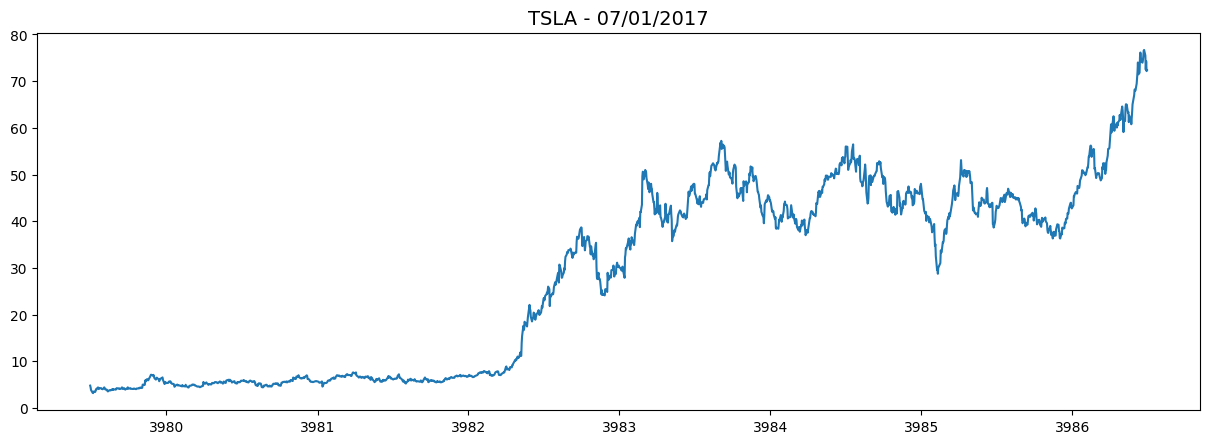

In [48]:
X, dates, end_val = process_and_plot_stocks_data(stocks)



In [24]:
model = train_gaussian_hmm(X)
hidden_states = decode_hidden_states_time_series(X, model)


[[7.77381950e-01 4.00208885e-46 1.33474488e-01 8.91435613e-02]
 [6.59567195e-06 9.31828143e-01 6.47817872e-02 3.38347433e-03]
 [1.37186273e-01 8.84530317e-02 7.60500161e-01 1.38605345e-02]
 [2.79073956e-01 3.85473188e-94 7.10318788e-03 7.13822856e-01]]


In [23]:
compute_mean_and_vars_hidden_state(model)

0th hidden state
mean =  [7.86421168e-02 6.59592583e+07]
var =  [3.54044781e+00 7.88355649e+14]
1th hidden state
mean =  [3.85918599e-02 1.55802673e+07]
var =  [3.04173299e-01 1.77303331e+13]
2th hidden state
mean =  [6.04249192e-03 4.90262172e+06]
var =  [1.89296820e-02 4.35411859e+12]
3th hidden state
mean =  [5.95084124e-02 3.00592684e+07]
var =  [1.18537975e+00 6.55303303e+13]


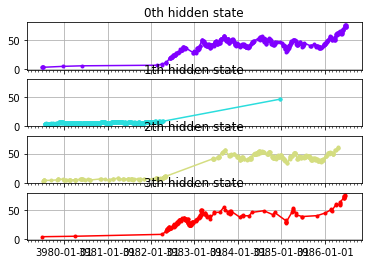

In [25]:
plot_trained_parameters(model, hidden_states, dates, end_val)